In [1]:
import tensorflow as tf
import numpy as np
import gpflow

from robust_gp import DSM_GPR
from diffusion_matrix import Shrinkage_Diffusion_matrix

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

2023-06-09 10:58:19.397526: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-09 10:58:19.410945: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-09 10:58:19.531772: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-09 10:58:19.534505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 10:58:21.664991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
plt.rcParams['figure.figsize'] = (12, 5)

(0.0, 20.0)

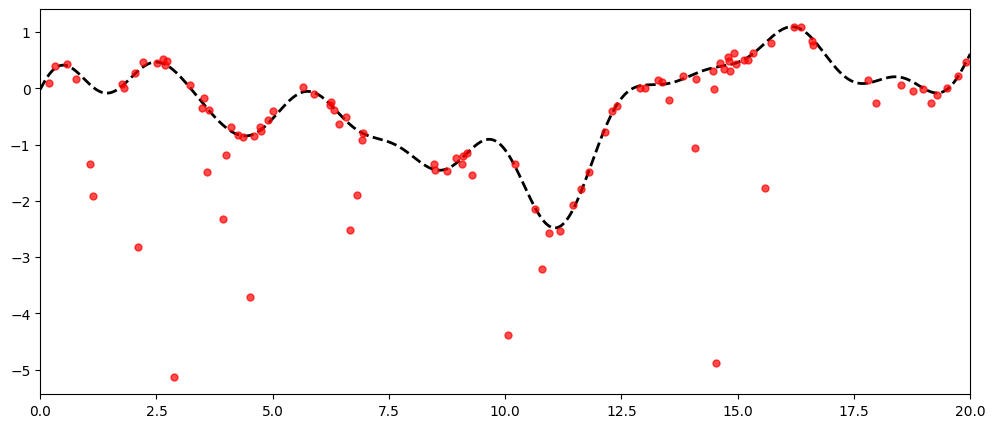

In [3]:
np.random.seed(10)
tf.random.set_seed(10)

n_points = 1000
sigma_n = 0.1
percent = 0.1
percent_miss = 0.2

kernel=gpflow.kernels.SquaredExponential()

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=len(i_obs)).reshape(len(i_obs), 1)
x_obs = x[i_obs]
n_obs = len(y_obs)

i_mis = np.random.choice(
    np.arange(0, n_obs, 1), int(percent_miss * n_obs), replace=False)

y_obs[i_mis] = y_obs[i_mis] - np.abs(np.random.normal(scale=2, size=len(i_mis))).reshape(len(i_mis),1)

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

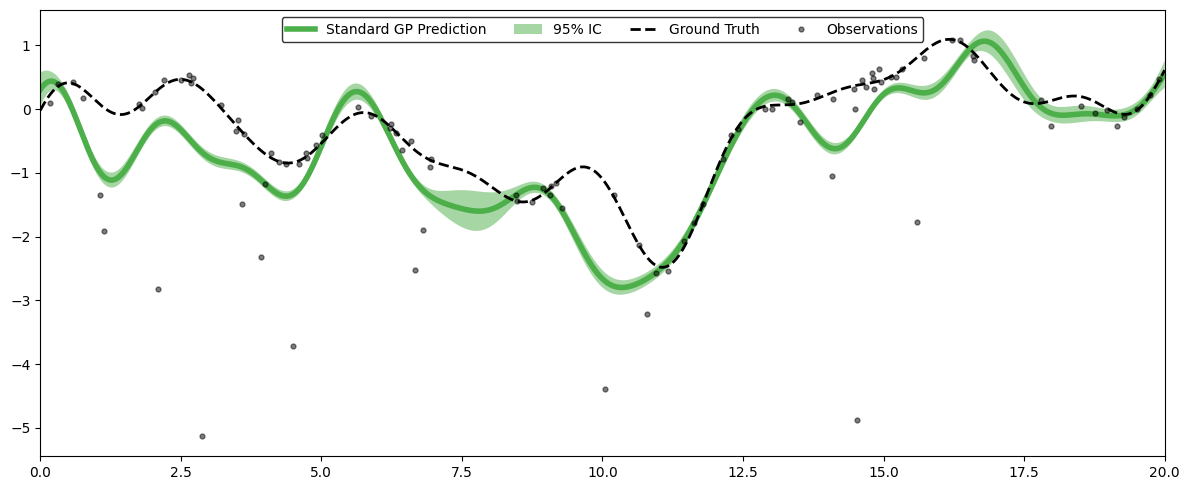

In [4]:
# plot estimation, obs and real data
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(),
    noise_variance=sigma_n**2
)
f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

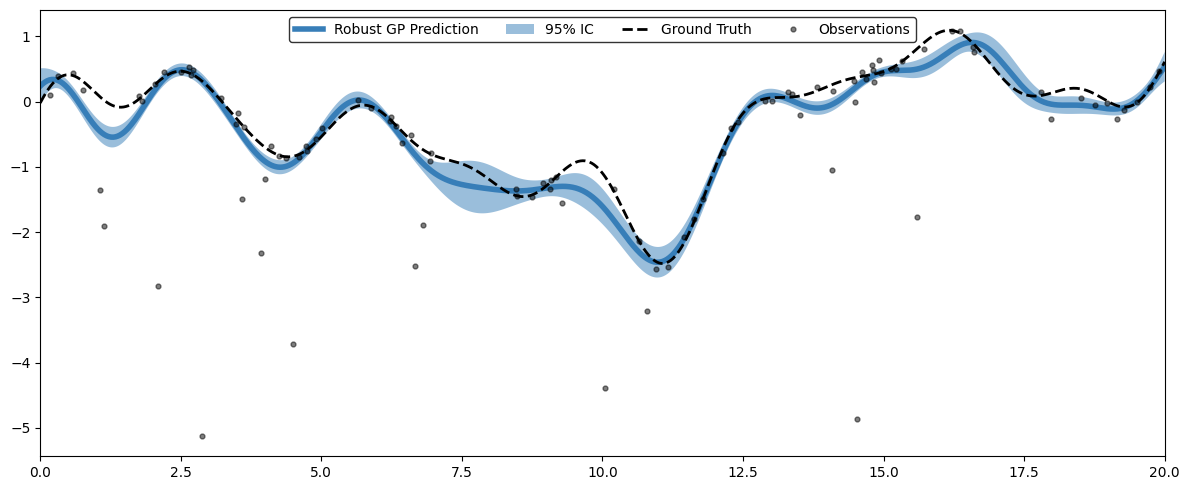

In [7]:
# plot estimation, obs and real data
dsm_gp = DSM_GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(),
    diffusion_matrix = Shrinkage_Diffusion_matrix(sigma_n**2),
    noise_variance=sigma_n**2 
)
f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)
plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

In [ ]:
plt.plot(x, f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x,
    f_mean - 1.96 * f_std,
    f_mean + 1.96 * f_std,
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x,
    f_mean_dsm - 1.96 * f_std_dsm,
    f_mean_dsm + 1.96 * f_std_dsm,
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')
plt.tight_layout()